In [1]:
from tensorflow.keras import datasets
from sklearn.metrics import confusion_matrix 
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
(x, y), _ = datasets.mnist.load_data()
x = (x.reshape(-1, 28 * 28) / x.max()) - 0.5
x.shape

(60000, 784)

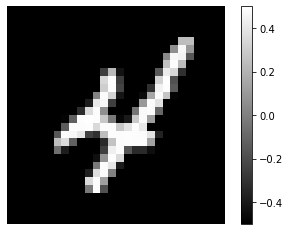

In [3]:
image = x[9].reshape(28,28)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.colorbar()
plt.show()

## test and train test

In [4]:
y_aux = np.zeros((len(x), 10))
for c in range(10):
  y_aux[:, c] = (y == c).astype(np.int16)
y = y_aux
y.shape

(60000, 10)

In [5]:
train_with = int(0.7 * len(x))
x_train = x[:train_with]
x_test = x[train_with:]
y_train = y[:train_with]
y_test = y[train_with:]
x_train.shape, x_test.shape

((42000, 784), (18000, 784))

## Xavier initialization

$n^{[l]}$: es la cantidad de neuronas en la capa $l$

$$\begin{aligned}W^{[l]} &\sim \mathcal{N}(\mu=0,\sigma^2 = \frac{1}{n^{[l-1]}})\\ b^{[l]} &= 0\end{aligned} $$
​	

In [6]:
config = [784, 70, 10]

W = []
for i in range(len(config) - 1):
    inputs = config[i]
    outputs = config[i+1]
    
    sigma = np.sqrt(1/inputs)

    w = sigma * np.random.randn(inputs + 1, outputs)
    w[0] = 0

    W.append(w)

[w.shape for w in W]

[(785, 70), (71, 10)]

## Activations And cost

In [7]:
# Activation function
def act(z):
    return 1/(1+np.exp(-z))
def d_act(z):
    return act(z)*(1-act(z))

# Cost function
def cost(a, y):
    m = len(a)
    return - (y * np.log(a) + (1-y) * np.log(1-a)).sum()/m
def d_cost(a, y):
    return (a-y)/(a*(1-a))

In [8]:
m, _ = x_train.shape
def __forward(f):
    m, n = f.shape
    A = [f]
    Z = []
    for w in W:
        n, _ = w.shape
        x0 = np.ones([m, n])
        x0[:, 1:] = A[-1]

        z = (x0 @ w)
        a = act(z)
        Z.append(z)
        A.append(a)

    return Z, A

def forward(f):
    Z, A = __forward(f)
    return A[-1]
pred = forward(x_train)

print(f'this should be {m, config[-1]} and got {pred.shape}')

this should be (42000, 10) and got (42000, 10)


## Backpropagation

In [9]:
def backprop(_x, _y, lr=1, mini_batch=400):

  idx = np.random.randint(len(_x), size=mini_batch)
  x = _x[idx, :]
  y = _y[idx, :]

  Z, A = __forward(x)

  e = cost(A[-1], y)

  d = d_cost(A[-1], y) * d_act(Z[-1])
  deltas = [None] * len(W)
  
  deltas[-1] = np.zeros(W[-1].shape)
  deltas[-1][0] = d.sum(axis=0) / mini_batch
  deltas[-1][1:] = (d.T @ A[-2]).T / mini_batch

  for i in range(2, len(W) + 1):
    z = Z[-i]
    w = W[-i+1]
    d = d @ w[1:].T * d_act(Z[-i])

    deltas[-i] = np.zeros(W[-i].shape)
    deltas[-i][0] = d.sum(axis=0) / mini_batch
    deltas[-i][1:] = (A[-i-1].T @ d) / mini_batch
  
  for i in range(len(W)):
    W[i] -= lr * deltas[i]
  
  return e

CPU times: user 32.1 s, sys: 3.26 s, total: 35.4 s
Wall time: 10.3 s


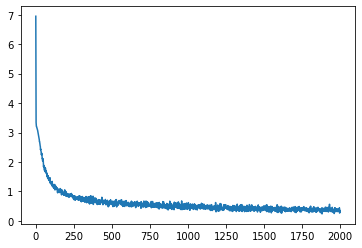

In [10]:
iterations = range(2000)
train = lambda: backprop(x_train, y_train, 0.5)

%time errors = [ train() for i in iterations]
plt.plot(iterations, errors)
plt.show()

## Metricas

In [11]:
a = forward(x_test)

y_aux = y_test.argmax(axis=1).reshape(-1, 1)
a_aux = a.argmax(axis=1).reshape(-1, 1)

results = (y_aux == a_aux).astype(np.int)
print(f'multi-layer logistic regresion has {results.sum() / len(results) * 100:.2f} of acuracy')

multi-layer logistic regresion has 94.23 of acuracy


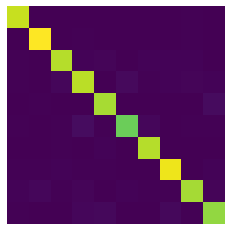

In [12]:
a = forward(x_test)

y_aux = y_test.argmax(axis=1).reshape(-1, 1)
a_aux = a.argmax(axis=1).reshape(-1, 1)

plt.imshow(confusion_matrix(y_aux, a_aux))
plt.axis('off')
plt.show()

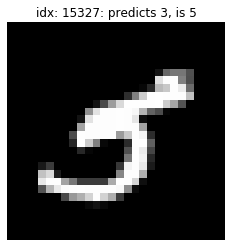

In [14]:
example = np.random.randint(len(x_test))
image = x_test[example]
a = forward(image.reshape(-1, 28*28)).argmax()
label = y_test[example].argmax()

plt.imshow(image.reshape(28,28), cmap='gray')
plt.axis('off')
plt.title(f'idx: {example}: predicts {a}, is {label}')
plt.show()

## Referencias

1. weights initialization - https://www.deeplearning.ai/ai-notes/initialization/
2. Vectorized algorithm - https://jonathanweisberg.org/post/A%20Neural%20Network%20from%20Scratch%20-%20Part%201/
3. Derivatives for backprop - http://neuralnetworksanddeeplearning.com/chap2.html